## Generalization 

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(3*'../')

import os
import glob
from pathlib import Path
from omegaconf import DictConfig
import yaml
import pickle
from collections import defaultdict


import torch
import lightning as L

from rl4co.envs import TSPEnv, CVRPEnv
from rl4co.tasks.rl4co import RL4COLitModule
from rl4co.utils.lightning import load_model_from_checkpoint, clean_hydra_config
from rl4co.tasks.eval import evaluate_policy


/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## Load solver solutions

In [2]:
device = torch.device("cuda:7")

exp_name = 'cvrp20'
env = CVRPEnv()
data_dir = Path("../data/vrp")


In [3]:
solver_path = Path("../solver/vrp")

# HGS
def load_solver_file(num_nodes):
    dir_ = solver_path / f"{num_nodes}_test_seed_1234"

    solver_files = sorted(glob.glob(str(dir_ / "*.txt")))
    # take the interger of file number and order by it
    solver_files = sorted(solver_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    costs = []
    for solver_file in solver_files:
        with open(solver_file, "r") as f:
            # get lines as dict
            lines = f.readlines()
            lines = [line.strip().split() for line in lines]
            lines = {line[0]: line[1:] for line in lines}
            costs.append(float(lines['obj_val:'][0]))
    print("Average cost: {:.2f}".format(sum(costs)/len(costs)))
    return costs

costs = load_solver_file(50)

Average cost: 10.37


## Loading datasets

In [4]:
# Get all files that contain "generalization*.npz" under data/tsp
files = glob.glob(str(data_dir / "*generalization*.npz"), recursive=True)
# files =  sorted(files)
# print(files)

num_nodes = [10, 20, 50, 75, 100, 125, 150, 200, 500, 1000]

datasets = []
for num_nodes_ in num_nodes:
    for file in files:
        if "vrp{}_test_generalization".format(num_nodes_) in file:
            dataset = env.dataset(filename=file, phase='test')
            solver_costs = load_solver_file(num_nodes_)
            datasets.append({'num_nodes': num_nodes_, 'file': file, 
                             'dataset': dataset, 'solver_costs': solver_costs})

Average cost: 4.58
Average cost: 6.13
Average cost: 10.37
Average cost: 13.27
Average cost: 15.56
Average cost: 17.61
Average cost: 19.14
Average cost: 21.83
Average cost: 36.69
Average cost: 49.85


## Loading model from checkpoint

In [5]:
def load_policy(exp_name, epoch, model_name):

    main_dir = Path('../../../saved_checkpoints/')

    main_dir = main_dir / exp_name / model_name

    cfg_path = main_dir / 'config.yaml'
    ckpt_path = main_dir / 'epoch_{}.ckpt'.format(epoch)

    lit_module = load_model_from_checkpoint(cfg_path, ckpt_path, phase='test')

    policy = lit_module.model.policy.to(device)
    policy.eval()
    return policy

In [6]:
def optimality_gap(bk_sol, opt_sol):
    return ((bk_sol - opt_sol) / bk_sol).mean().item() * 100

In [7]:
def get_generalization_stats(policy):
    stats = defaultdict(list)

    for dataset in datasets:
        print("====================")
        print("Evaluating dataset: {}".format(dataset['file']))
        stats['num_nodes'].append(dataset['num_nodes'])
        stats['file'].append(dataset['file'])
        out_dict = evaluate_policy(env, policy, dataset['dataset'], method='greedy', max_batch_size=128)

        model_costs = -out_dict['rewards']
        solver_costs = torch.Tensor(dataset['solver_costs'][:1000]) # by default, we only evaluate on 1000 samples

        stats['model_cost_mean'].append(model_costs.mean())
        stats['solver_cost_mean'].append(solver_costs.mean())
        gap = optimality_gap(model_costs, solver_costs)
        stats['optimality_gap'].append(gap)

        print("Optimality gap: {:.2f}%".format(gap))

    return stats

In [8]:
# # GNN
# model_name = "gnn"
# epoch = "099"
# model = load_policy(exp_name, epoch, model_name)
# am_critic_stats = get_generalization_stats(model)

In [9]:
# AM Critic
model_name = f"am-critic-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
am_critic_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1353345, 'trainable': 1353345, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -4.7975
Time: 0.2805s
Optimality gap: 2.00%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.4826
Time: 0.3065s
Optimality gap: 3.99%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.4675
Time: 0.6696s
Optimality gap: 8.56%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -15.1703
Time: 0.9833s
Optimality gap: 12.35%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -18.4181
Time: 1.2799s
Optimality gap: 15.24%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -21.2752
Time: 1.5840s
Optimality gap: 17.17%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -23.9108
Time: 1.8786s
Optimality gap: 19.67%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -28.5936
Time: 2.4991s
Optimality gap: 23.33%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -56.1573
Time: 8.0399s
Optimality gap: 34.23%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -106.6956
Time: 22.4486s
Optimality gap: 51.82%


In [10]:
# AM
model_name = f"am-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
am_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 692608, 'trainable': 692608, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -4.8000
Time: 0.1916s
Optimality gap: 2.16%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.4124
Time: 0.3038s
Optimality gap: 2.94%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.4958
Time: 0.6657s
Optimality gap: 8.75%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -15.2308
Time: 0.9749s
Optimality gap: 12.68%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -18.4224
Time: 1.2768s
Optimality gap: 15.23%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -21.2684
Time: 1.5686s
Optimality gap: 17.13%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -23.9284
Time: 1.8797s
Optimality gap: 19.71%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -28.7456
Time: 2.4959s
Optimality gap: 23.70%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -58.6597
Time: 7.8224s
Optimality gap: 36.75%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -109.5439
Time: 23.5116s
Optimality gap: 51.64%


In [11]:
# POMO
model_name = f"pomo-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
pomo_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1285888, 'trainable': 1285888, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -4.8844
Time: 0.2228s
Optimality gap: 3.79%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.3470
Time: 0.3320s
Optimality gap: 1.97%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.6501
Time: 0.6905s
Optimality gap: 9.94%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -15.5377
Time: 1.0095s
Optimality gap: 14.36%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -18.9454
Time: 1.3040s
Optimality gap: 17.52%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -22.0029
Time: 1.5998s
Optimality gap: 19.86%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -24.8721
Time: 1.9246s
Optimality gap: 22.72%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -30.2932
Time: 2.5288s
Optimality gap: 27.57%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -69.9765
Time: 7.8071s
Optimality gap: 46.97%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -144.0562
Time: 21.5495s
Optimality gap: 64.22%


In [12]:
# SymNCO
model_name = f"symnco-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
symnco_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1318912, 'trainable': 1318912, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -4.9156
Time: 0.2115s
Optimality gap: 4.40%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.3292
Time: 0.3293s
Optimality gap: 1.67%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.7015
Time: 0.7010s
Optimality gap: 10.31%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -15.6633
Time: 1.0120s
Optimality gap: 15.08%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -19.8839
Time: 1.3157s
Optimality gap: 21.43%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -24.9642
Time: 1.6216s
Optimality gap: 29.30%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -30.6673
Time: 1.9805s
Optimality gap: 37.24%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -43.8050
Time: 2.6458s
Optimality gap: 49.32%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -143.7520
Time: 8.8580s
Optimality gap: 73.54%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -299.8331
Time: 23.9203s
Optimality gap: 82.78%


In [13]:
# AM-xl
model_name = f"am-{exp_name}-sm-xl"
epoch = "499"
model = load_policy(exp_name, epoch, model_name)
am_xl_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1285888, 'trainable': 1285888, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -4.8911
Time: 0.2094s
Optimality gap: 3.98%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.3418
Time: 0.3303s
Optimality gap: 1.88%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.6883
Time: 0.8251s
Optimality gap: 10.25%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -15.5231
Time: 1.1514s
Optimality gap: 14.32%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -18.9890
Time: 1.3173s
Optimality gap: 17.77%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -22.2640
Time: 1.6285s
Optimality gap: 20.89%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -25.6106
Time: 1.9536s
Optimality gap: 25.01%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -32.2049
Time: 2.6010s
Optimality gap: 31.84%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -69.2148
Time: 8.0993s
Optimality gap: 46.55%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -112.4165
Time: 22.3297s
Optimality gap: 55.34%


In [14]:
experiments = { 
    'am-critic': am_critic_stats,
    'am': am_stats,
    'pomo': pomo_stats, 
    'symnco': symnco_stats,
    'am-xl': am_xl_stats,
}

colors = {
    'am-critic': 'tab:red',
    'am': 'tab:blue',
    'pomo': 'tab:orange',
    'symnco': 'tab:green',
    'am-xl': 'tab:purple',
}

labels = {
    'am-critic': 'AM-critic',
    'am': 'AM',
    'pomo': 'POMO',
    'symnco': 'SymNCO',
    'am-xl': 'AM-XL',
}

In [15]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({'text.usetex': True,
                    'font.family': 'serif',
                    # 'font.size': 16,
})

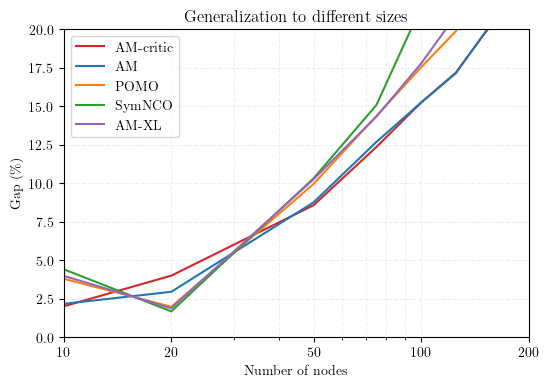

In [16]:

fig, ax = plt.subplots(figsize=(6,4))

data_generalization = defaultdict(list)

for experiment in experiments:
    # add data to save and plot
    stats = experiments[experiment]
    data_generalization[experiment] = stats

    ax.plot(stats['num_nodes'], stats['optimality_gap'], label=labels[experiment], color=colors[experiment])

# log scale
ax.set_xscale('log')
# ax.set_yscale('log')

# cut plot at 10 nodes
# ax.set_xlim([10, 1000])
ax.set_xlim([10, 200])

# replace x-axis ticks
# ax.set_xticks([10, 20, 50, 100, 200, 500, 1000])
ax.set_xticks([10, 20, 50, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# Set plot title
ax.set_title('Generalization to different sizes')

# Set x-axis label
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Gap (\%)')

ax.set_ylim([0, 20])
ax.set_ylim([0, None])

# Training size: draw vertical line at num_nodes = stats['num_nodes'][-1]
# ax.axvline(x=stats['num_nodes'][-1])#, color='tab:red', linestyle='--', linewidth=1)

# Set grid on with dashed lines for log scale
ax.grid(True, which="both", ls="--", color='0.93')

# legend
ax.legend(loc='upper left')

# Save plot data
save_folder = Path('plots/')
save_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(save_folder / f'{exp_name}.pdf', bbox_inches='tight')

# Save data with pickle
with open(save_folder / f'{exp_name}_data.pkl', 'wb') as f:
    pickle.dump(data_generalization, f)